In [23]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import tpp_preprocess as tpp
import hpp_checker as hpp
import pyteomics.auxiliary as aux

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue",
                "Canon_unique":"salmon", "NonCanon_unique":"skyblue", "Shared":"darkkhaki",
                "Canon":"firebrick","Noncanon":"steelblue"}

In [6]:
peptide_classes={"NonCanon_unique":["unique_to_Noncanon",'shared_in_Noncanon'],
                "Canon_unique":["unique_to_Canon",'shared_in_Canon'],
                "Shared":['shared_btw_can_noncan']}

In [17]:
working_folder = "./../msfragger_pride_reanalysis/fragpipe23_ms42/"
work_subdirs_db=["canon","trembl","openprot"]
work_subdirs_dts=["PXD002057","PXD005833","PXD014258"]
figsave_folder="./oui_discovery_subfigures/explore-1-msfragger/"
wildcard="msfr"

In [8]:
dt.list_files(working_folder)

In [9]:
mgfspectraN_datasets=pickle.load(open('./../mgfspectraN_datasets.pickle', 'rb'))

In [10]:
def find_files(root_dir, target_filename_prefix):
    result_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        #print(filenames)
        if any(target_filename_prefix in x for x in filenames):
            #print(filenames)
            target_filenames=[x for x in filenames if target_filename_prefix in x]
            for target_filename in target_filenames:
                file=os.path.join(dirpath, target_filename)
                file=file.replace("\\", "/")
                result_files.append(file)
    return result_files
def load_philosopher_output(root_dir,target_filename_prefix="mod.pep.xml"):
    files=find_files(root_dir,target_filename_prefix)
    print(files)
    dfs=[]
    for file in files:    
        if "pep" in target_filename_prefix:
            with pepxml.read(file) as reader:
                data = list(reader)
        if "prot" in target_filename_prefix:
            with protxml.read(file) as reader:
                data = list(reader)
        df = pd.DataFrame(data)
        df["spectrum_file"]=file.split("/")[-2]#.replace("interact-","").replace(target_filename_prefix,"")
        df["dataset"]=file.split("/")[-3]
        df["database"]=file.split("/")[-4]
        dfs.append(df)
    files_df=pd.concat(dfs)
    return files_df
def get_hitclass(row):
    #print(row)
    proteins=[hit if 'protein_descr' in hit.keys() else {'protein_descr':hit['protein']} for hit in row[0]['proteins']]
    proteins=[hit if len(hit['protein_descr'])>1 else {'protein_descr':hit['protein']} for hit in proteins]
    vals=[ "D" if "decoy" in hit['protein_descr'] else "NC" if "no_match" in hit['protein_descr'] or (("II_" in hit['protein_descr'] or "IP_" in hit['protein_descr']) and "protein" not in hit.keys()) else "CONTAM" if "CONTAM" in hit['protein_descr'] or "contam" in hit['protein_descr'] else "T"  for hit in proteins ]
    #print(proteins)
    #print(vals)
    if any("D"==x for x in vals):
        return "D"
    if any("CONTAM"==x or "contam"==x for x in vals):
        return "CONTAM"
    if all("NC"==x for x in vals):
        return "NC"
    else:
        return "T"
    
def get_proteins(row):
    return "||".join([hit['protein'] for hit in row[0]['proteins']])

def get_pepclass(row):
    #print(row) #here was a mistake with D
    if row["hit_class"]=="D":
        pepclass="Decoy"
    if row["hit_class"]=="CONTAM":
        pepclass="Contam"
    elif row["hit_class"]=="NC":
        pepclass="shared_in_Noncanon" if "||" in row["proteins"] else "unique_to_Noncanon"
    else:
        proteins=[hit if 'protein_descr' in hit.keys() else {'protein_descr':hit['protein']} for hit in row["search_hit"][0]['proteins']]
        proteins=[hit if len(hit['protein_descr'])>1 else {'protein_descr':hit['protein']} for hit in proteins]
        vals=["NC" if "no_match" in hit['protein_descr'] or ("II_" in hit['protein_descr'] or "IP_" in hit['protein_descr']) else "C"  for hit in proteins]
        pepclass="shared_in_Canon" if all("C"==v for v in vals) and len(vals)>1 else "unique_to_Canon" if all("C"==v for v in vals) and len(vals)==1 else "shared_btw_can_noncan"
    return pepclass

def parse_search_hit(row,feature):
    row=row[0]
    if not isinstance(feature,list):
        if feature in row.keys():
            return row[feature]
    if isinstance(feature,list):
        item=row
        for i in range(len(feature)):
            if isinstance(item,list) and i!=len(feature)-1:
                item=item[0]
            #print(item)
            item=item[feature[i]] if feature[i] in item.keys() else None
            if item==None:
                return None
    return item    
def init_file(df):
    df["proteins"]=df.search_hit.apply(get_proteins)
    df["hit_class"]=df.search_hit.apply(get_hitclass)
    df["peptide_class"]=df.apply(get_pepclass,axis=1)
    ask_features=["peptide","num_missed_cleavages",'num_tot_proteins',['search_score','expect'],
                  ["analysis_result","peptideprophet_result","parameter","fval"],['analysis_result','peptideprophet_result','probability'],
             ['ptm_result','localization'],['ptm_result','ptm_mass'],['ptm_result','localization_peptide'],
                  'modified_peptide','modifications','massdiff','calc_neutral_pep_mass']
    for feature in ask_features:
        col=":".join(feature) if isinstance(feature,list) else feature
        df[col]=df.search_hit.apply(lambda x: parse_search_hit(x,feature))
    return df
def get_qval(df,score="analysis_result:peptideprophet_result:parameter:fval"):
    """ calculate FDR and q-values based on score"""
    df = df.sort_values(by=score, ascending=False).reset_index(drop=True)        
    # Calculate cumulative counts of targets and decoys
    df['cum_targets'] = (df['hit_class'] != 'D').cumsum()
    df['cum_decoys'] = (df['hit_class'] == 'D').cumsum()
    # Calculate FDR
    df['FDR'] = df['cum_decoys'] / df['cum_targets']
    # cumulative minimum from bottom to top
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  
    df["q-value"].fillna(0,inplace=True)
    return df
def get_qval_prot(df,score="confidence"):
    """ calculate FDR and q-values based on score"""
    df = df.sort_values(by=score, ascending=False).reset_index(drop=True)        
    # Calculate cumulative counts of targets and decoys
    df['cum_targets'] = (df['protein_class'] != 'Decoy').cumsum()
    df['cum_decoys'] = (df['protein_class'] == 'Decoy').cumsum()
    # Calculate FDR
    df['FDR'] = df['cum_decoys'] / df['cum_targets']
    # cumulative minimum from bottom to top
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  
    df["q-value"].fillna(0,inplace=True)
    return df

In [25]:
def classify_leadprot(x):
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def classifiy_mods(row):
    if pd.isna(row["modifications:type_re"]):
        return 'Unmodified'
    elif row["modifications:type_re"]=="unexpected":
        return 'Unexpected'
    else:
        return 'Expected'

def custom_subgroup_filter(data_):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key='analysis_result:peptideprophet_result:parameter:fval', reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='custom_q')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

### Load PeptideProphet

In [ ]:
#pepxml after PTMProphet

prophet_combined_datasets={}
for work_subdir in work_subdirs_dts:
    data_frames = {}
    for database in work_subdirs_db:
        path=os.path.join(working_folder,database,work_subdir)
        print(path)
        data_frames[database]=load_philosopher_output(path)
        print(data_frames[database].shape)
    prophet_combined_datasets[work_subdir] = data_frames

### Extract features and get global FDR

In [ ]:
#add decoy/target columns, calculate q-value based on fval

for dataset, subdict in prophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        #extract features
        df_ds=init_file(df_ds)
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            print(dataset,database,spectrum_file)
            df=df_ds.loc[df_ds.spectrum_file==spectrum_file]
            df=get_qval(df)
            df_ds_new.append(df)
        prophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

In [12]:
##prophet_combined_datasets=pickle.load(open("./../prophet_combined_datasets.pkl","rb"))

### Add modifications

In [15]:
def load_ptmshepherd_output(root_dir,filename="global.profile.tsv"):   
    files=find_files(root_dir,filename)
    print(files)
    dfs=[]
    for file in files:
        df=pd.read_csv(file,sep="\t")
        #fix file, run once
        df.reset_index(inplace=True)
        df.columns=df.columns.tolist()[1:]+["drop"]
        df.drop("drop",axis=1,inplace=True)
        df["spectrum_file"]=file.split("/")[-2]#.replace("interact-","").replace(target_filename_prefix,"")
        df["dataset"]=file.split("/")[-3]
        df["database"]=file.split("/")[-4]
        dfs.append(df)
    files_df=pd.concat(dfs)
    return files_df
def annotate_massshift(value,ptm_df,col):
    #print(value)
    a=ptm_df[(ptm_df['peak_lower'] <= value) & (ptm_df['peak_upper'] >= value)]
    if len(a[col])==0: 
        return None
    return "||".join(set([str(x).split("shift ")[-1] if "Unidentified" in str(x) or "Unannotated" in str(x) else str(x) for x in a[col].values.tolist()]))

def extract_trivial_aa(x):
    if not x["trivial_localization"]:
        return None
    peptide = x["ptm_result:localization_peptide"]
    filtered = [i for i in peptide if i.lower() == i]
    return filtered[0].upper()

In [18]:
#profile after PTMShepherd

data_ptm=load_ptmshepherd_output(working_folder)

['./../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_SampleHela/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_Sample_BT474/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_Sample_MCF/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_02_hu_P1_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_03_hu_C2_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_05_hu_C3_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_06_hu_P3_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_04_hu_P2_2hr/ptm-shepherd-

In [19]:
expected_mods={57.0215,15.9949, 42.0106}
expected_mods_name=['Iodoacetamide derivative/Addition of Glycine/Addition of G','Oxidation or Hydroxylation','Acetylation']

In [20]:
for dataset, subdict in prophet_combined_datasets.items():
    for database,data in subdict.items():
        # fixed and variable PTM annotation
        data['ptm_result:ptm_mass']=data['ptm_result:ptm_mass'].astype(float)
        #mass shift annotation
        data["mapped_mass_1"]=np.nan
        data["mapped_mass_2"]=np.nan
        data["mapped_mass_1"]=data["ptm_result:ptm_mass"].apply(lambda x: annotate_massshift(float(x) if isinstance(x,str) else x,data_ptm,"mapped_mass_1"))
        data["mapped_mass_2"]=data["ptm_result:ptm_mass"].apply(lambda x: annotate_massshift(float(x) if isinstance(x,str) else x,data_ptm,"mapped_mass_2"))
        data["n_apex"]=data["mapped_mass_1"].apply(lambda x: len(x.split("||")) if isinstance(x,str) else 0)
        #reannotate variable modifications based on mapped_mass_1
        data["modifications:type_re"]=data.apply(lambda x: np.nan if not isinstance(x["mapped_mass_1"],str) 
                                                                   else "variable" if any([mod in x["mapped_mass_1"] for mod in expected_mods_name])
                                                                   else "unexpected" ,axis=1)
        prophet_combined_datasets[dataset][database]=data

### Custom and hybrid FDR

In [33]:
for dataset, subdict in prophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        #extract features
        df_ds=init_file(df_ds)
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            print(dataset,database,spectrum_file)
            data=df_ds.loc[df_ds.spectrum_file==spectrum_file]

            data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
            
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            
            df_ds_new.append(data2)
        prophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

PXD002057 canon 130327_o2_03_hu_C2_2hr
PXD002057 canon 130327_o2_05_hu_C3_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 canon 130327_o2_06_hu_P3_2hr
PXD002057 canon 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 canon 130327_o2_02_hu_P1_2hr
PXD002057 canon 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

PXD002057 trembl 130327_o2_03_hu_C2_2hr
PXD002057 trembl 130327_o2_05_hu_C3_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 trembl 130327_o2_06_hu_P3_2hr
PXD002057 trembl 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 trembl 130327_o2_02_hu_P1_2hr
PXD002057 trembl 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 openprot 130327_o2_03_hu_C2_2hr
PXD002057 openprot 130327_o2_05_hu_C3_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 openprot 130327_o2_06_hu_P3_2hr
PXD002057 openprot 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD002057 openprot 130327_o2_02_hu_P1_2hr


/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

PXD002057 openprot 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)


PXD005833 canon AM13


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM7
PXD005833 canon AM18


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM20
PXD005833 canon AM12


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

PXD005833 canon AM14


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

PXD005833 canon AM16


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)


PXD005833 canon AM9


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM15


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM11


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM19


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM21
PXD005833 canon AM10


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 canon AM17
PXD005833 canon AM8


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

PXD005833 trembl AM13


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM7
PXD005833 trembl AM18


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM20


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

PXD005833 trembl AM12


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

PXD005833 trembl AM14


/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)


PXD005833 trembl AM16


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM9


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM15


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM11


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM19


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM21
PXD005833 trembl AM10


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM17


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 trembl AM8


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM13


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM7
PXD005833 openprot AM18


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM20


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM12


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM14


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM16


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM9


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM15


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM11


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM19


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM21


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM10


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM17


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD005833 openprot AM8


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 canon ESC_HF_Sample_BT474


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 canon ESC_HF_SampleHela


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 canon ESC_HF_Sample_MCF


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 trembl ESC_HF_Sample_BT474


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 trembl ESC_HF_SampleHela


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 trembl ESC_HF_Sample_MCF


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 openprot ESC_HF_Sample_BT474


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 openprot ESC_HF_SampleHela


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

PXD014258 openprot ESC_HF_Sample_MCF


/tmp/ipykernel_3338008/3528274130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_3338008/3528274130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_3338008/3528274130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [34]:
pickle.dump(prophet_combined_datasets,open("prophet_combined_datasets.pkl","wb"))

In [ ]:
prophet_combined_datasets=pickle.load(open("prophet_combined_datasets.pkl","rb"))

#### Save into table to do protein inference with ionbot pipeline

In [28]:
#comb_peproph=pd.DataFrame()
#for dataset, subdict in prophet_combined_datasets.items():
#    for database,data in subdict.items():
#        data["searchDB"]=database
#        comb_peproph=pd.concat([comb_peproph,data])
#comb_peproph.to_csv("./group-wise-tpp-fragpipe-psm/fragpipe_peptideprophet_custom_unfilt.csv",index=False)

In [32]:
#hybrid - bad: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q
#comb_peproph["glob_cust_hybrid"]=comb_peproph.apply(lambda x: x["q-value"] if x.isCanonical else x["custom_q"], axis=1)
#comb_peproph.to_csv("./group-wise-tpp-fragpipe-psm/fragpipe_peptideprophet_custom_unfilt.csv",index=False)

In [35]:
#del comb_peproph

### Filter by hybrid q-value, decoy and contaminants

In [36]:
prophet_filt_combined_datasets={"PXD002057":{},"PXD005833":{},"PXD014258":{}}
for dataset_name in prophet_combined_datasets:
    for database in prophet_combined_datasets[dataset_name]:
        df=prophet_combined_datasets[dataset_name][database]
        prophet_filt_combined_datasets[dataset_name][database]=df.loc[(df['glob_cust_hybrid']<0.01)&(df.isCanonical!="Contam")&(df["hit_class"]!="D"),:]

In [37]:
pickle.dump(prophet_filt_combined_datasets,open("msfr_prophet_filt_combined_datasets.pkl","wb"))

### Identification rate by search

In [38]:
#as tpp does not record spectra file (but merged, input), then add up corresponding merged files n of spectra

#PXD014258
mgfspectraN_datasets['PXD014258.v0.11.4']={f"{i}.mgf":np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)]) 
     if "BT474" not in i 
    else np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)])
     for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]
}

In [39]:
del mgfspectraN_datasets['PXD003594.v0.11.4']

In [40]:
#ID rate on target, filtered

prophet_idrate_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
for dataset_name in prophet_filt_combined_datasets:
    idrate_med={"canon":[],"trembl":[],"openprot":[]}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=prophet_filt_combined_datasets[dataset_name][database]
        ##dff=df[df["hit_class"]!="D"]
        for spectrum_file, group in df.groupby("spectrum_file"):
            if dataset_name=="PXD014258": spectrum_file=spectrum_file.replace("_","-")
            nspec=mgfspectraN[spectrum_file+".mgf"]
            idrate=(len(group)/nspec)
            idrate_med[database].append(idrate)
    prophet_idrate_datasets[dataset_name]=idrate_med

In [41]:
prophet_idrate_datasets_df=pd.DataFrame(columns=["pipeline","sample","database","value"])
for dataset in prophet_idrate_datasets:
    for database in prophet_idrate_datasets[dataset]:
        for i,val in enumerate(prophet_idrate_datasets[dataset][database]):
            prophet_idrate_datasets_df.loc[len(prophet_idrate_datasets_df)]=["FragPipe",f"{dataset}_{i}",database,val]
prophet_idrate_datasets_df.to_pickle("msfr_idrate_datasets_df.pkl")

### Searches overlap

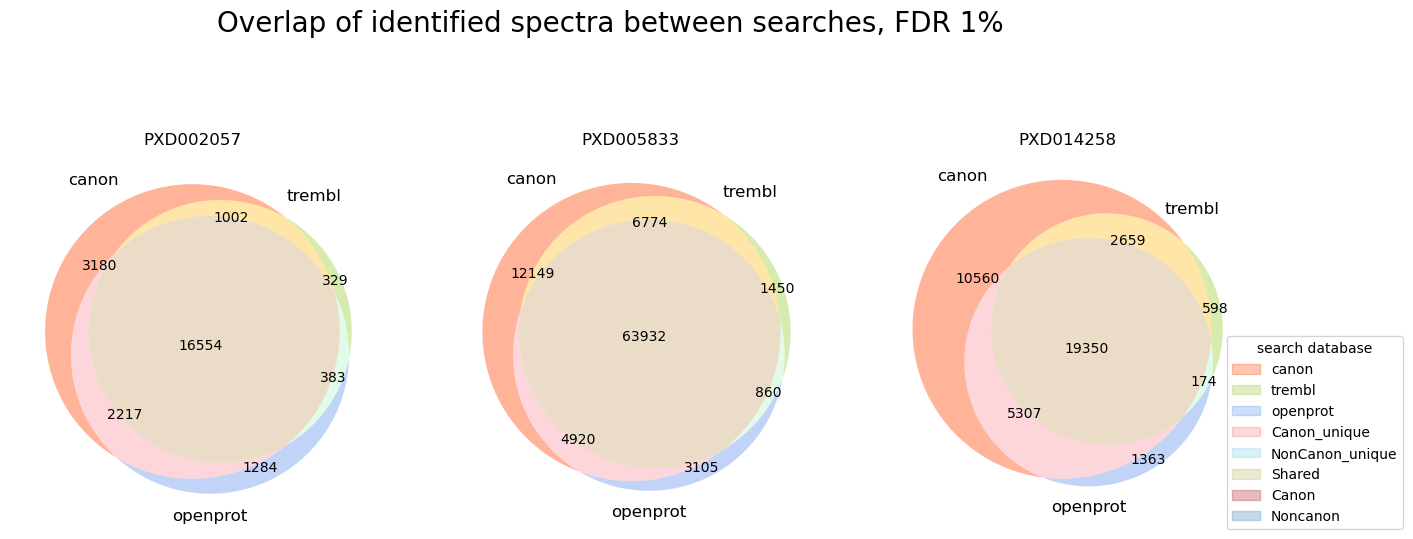

In [44]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(prophet_filt_combined_datasets):
    dfs=list(prophet_filt_combined_datasets[dataset_name].values())
    databases=list(prophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum),set(dfs[1].spectrum),set(dfs[2].spectrum)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

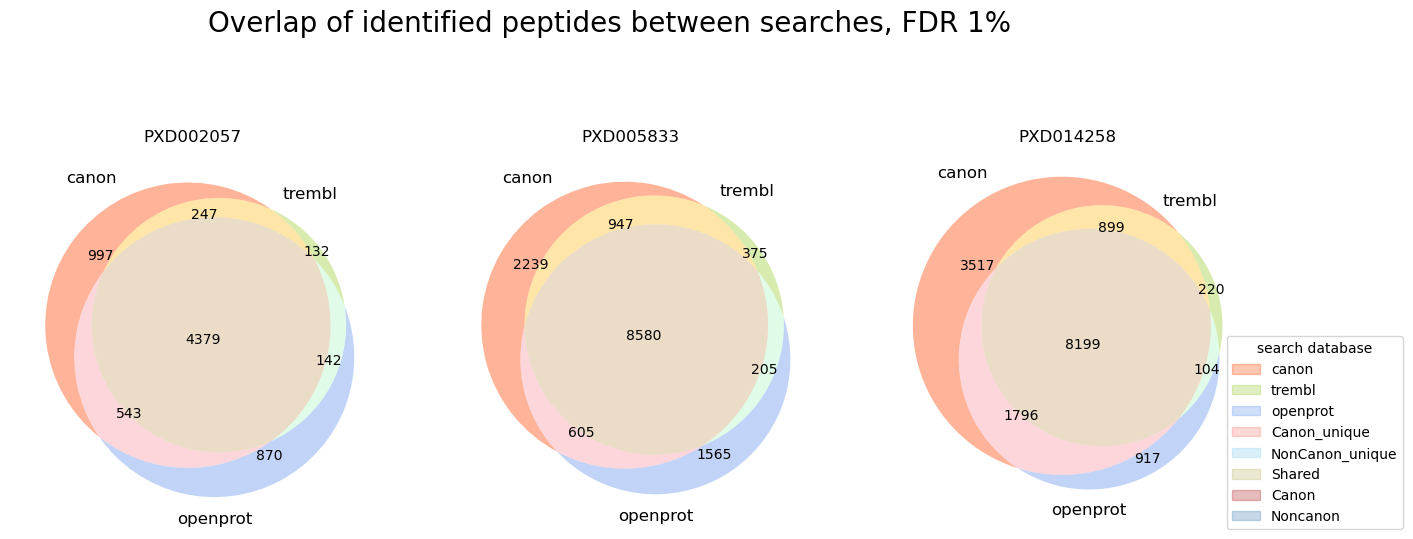

In [45]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(prophet_filt_combined_datasets):
    dfs=list(prophet_filt_combined_datasets[dataset_name].values())
    databases=list(prophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].peptide),set(dfs[1].peptide),set(dfs[2].peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

### Peptide & protein class

In [46]:
#peptides shared vs proteotypic 

pepsharedproteotyp_df=pd.DataFrame(columns=["pipeline","database","peptide_class","value"])
for database in ["canon","trembl","openprot"]:    
    df=pd.concat([prophet_filt_combined_datasets[dataset_name][database] for dataset_name in prophet_filt_combined_datasets])
    ##df=df[(df["hit_class"]!="D")]
    counts=Counter(df.drop_duplicates(["peptide"]).peptide_class)
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["FragPipe",database,"shared",np.sum([val for key,val in counts.items() if "shared" in key])]
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["FragPipe",database,"proteotypic",np.sum([val for key,val in counts.items() if "unique" in key])]
pepsharedproteotyp_df.to_pickle("msfr_peptype_df.pkl")

### Identification rate by peptide class

In [48]:
prophet_PEPCL_idrate_datasets_df=pd.DataFrame(columns=["pipeline","dataset","peptide_class","value"])
pepcl_order=["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
datasets_index=[f"{dataset_name.replace(".v0.11.4","")}_{i}" for dataset_name,vals in mgfspectraN_datasets.items() for i in range(len(vals))]
prophet_PEPCL_idrate_datasets_df["pipeline"]=["FragPipe"]*len(pepcl_order)*len(datasets_index)
prophet_PEPCL_idrate_datasets_df["dataset"]=datasets_index*len(pepcl_order)
prophet_PEPCL_idrate_datasets_df["peptide_class"]=sorted(pepcl_order*len(datasets_index))

for dataset_name in prophet_filt_combined_datasets:
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    database="openprot"
    df=prophet_filt_combined_datasets[dataset_name][database]
    ##df=df[df["hit_class"]!="D"]
    for peptide_class in pepcl_order:   
        dff=df[df.peptide_class==peptide_class]
        values=[]
        for spectrum_file, _ in df.groupby("spectrum_file"): #to avoid sp files with no pep cl
            group=dff[dff.spectrum_file==spectrum_file]
            print(peptide_class,spectrum_file)
            if len(group)==0: 
                values.append(0)
                continue
            if dataset_name=="PXD014258": spectrum_file=spectrum_file.replace("_","-")
            nspec=mgfspectraN[spectrum_file+".mgf"]
            idrate=(len(group)/nspec)
            values.append(idrate)
        prophet_PEPCL_idrate_datasets_df.loc[(prophet_PEPCL_idrate_datasets_df.dataset.str.contains(dataset_name.replace(".v0.11.4","")))&
            (prophet_PEPCL_idrate_datasets_df.peptide_class==peptide_class),"value"]=values
prophet_PEPCL_idrate_datasets_df.to_pickle("msfr_PEPCL_idrate_datasets_df.pkl")

unique_to_Noncanon 130327_o2_01_hu_C1_2hr
unique_to_Noncanon 130327_o2_02_hu_P1_2hr
unique_to_Noncanon 130327_o2_03_hu_C2_2hr
unique_to_Noncanon 130327_o2_04_hu_P2_2hr
unique_to_Noncanon 130327_o2_05_hu_C3_2hr
unique_to_Noncanon 130327_o2_06_hu_P3_2hr
shared_in_Noncanon 130327_o2_01_hu_C1_2hr
shared_in_Noncanon 130327_o2_02_hu_P1_2hr
shared_in_Noncanon 130327_o2_03_hu_C2_2hr
shared_in_Noncanon 130327_o2_04_hu_P2_2hr
shared_in_Noncanon 130327_o2_05_hu_C3_2hr
shared_in_Noncanon 130327_o2_06_hu_P3_2hr
unique_to_Canon 130327_o2_01_hu_C1_2hr
unique_to_Canon 130327_o2_02_hu_P1_2hr
unique_to_Canon 130327_o2_03_hu_C2_2hr
unique_to_Canon 130327_o2_04_hu_P2_2hr
unique_to_Canon 130327_o2_05_hu_C3_2hr
unique_to_Canon 130327_o2_06_hu_P3_2hr
shared_in_Canon 130327_o2_01_hu_C1_2hr
shared_in_Canon 130327_o2_02_hu_P1_2hr
shared_in_Canon 130327_o2_03_hu_C2_2hr
shared_in_Canon 130327_o2_04_hu_P2_2hr
shared_in_Canon 130327_o2_05_hu_C3_2hr
shared_in_Canon 130327_o2_06_hu_P3_2hr
shared_btw_can_noncan 130327

### Peptides' reproducability

In [50]:
#across all samples

peptides_across_samples_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    peptides_across_samples_l=[]
    for dataset_name in prophet_filt_combined_datasets:
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]#(df["hit_class"]!="D")&
        peptides_across_samples_l=peptides_across_samples_l+list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
    peptides_across_samples_d=Counter(peptides_across_samples_l)
    peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/23 #number of samples
    keys=list(peptides_across_samples_d.keys())
    for i,row in enumerate(peptides_across_samples):
        peptides_across_samples_df.loc[len(peptides_across_samples_df)]=["FragPipe",keys[i],peptide_class,row]
peptides_across_samples_df.to_pickle("msfr_peptides_across_samples_df.pkl")

In [51]:
#across samples of same PXD

peptides_across_samples_PXD_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    #peptides_across_samples_l=[]
    for dataset_name in prophet_filt_combined_datasets:
        key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
        mgfspectraN=mgfspectraN_datasets[key]
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peptides_across_samples_l=list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
        peptides_across_samples_d=Counter(peptides_across_samples_l)
        peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/len(mgfspectraN) #number of samples
        keys=list(peptides_across_samples_d.keys())
        for i,row in enumerate(peptides_across_samples):
            peptides_across_samples_PXD_df.loc[len(peptides_across_samples_PXD_df)]=["FragPipe",keys[i],peptide_class,row]
peptides_across_samples_PXD_df.to_pickle("msfr_peptides_across_samples_PXD_df.pkl")

In [52]:
#count by PXD

peptides_across_samples_PEP_df=pd.DataFrame(columns=["pipeline","PXD","peptide_class","value","count"])
for dataset_name in prophet_filt_combined_datasets:
    for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peptides_across_samples_l=list(df.peptide.unique())
        tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
        for spectrum_file in tmp.columns:
            tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
        tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,1,len(tmp[tmp["count"]==1])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,2,len(tmp[tmp["count"]==2])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,3,len(tmp[tmp["count"]==3])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,4,len(tmp[tmp["count"]>3])]

In [53]:
#add all

for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    df=pd.concat([prophet_filt_combined_datasets[dataset_name]["openprot"] for dataset_name in prophet_filt_combined_datasets])
    df=df[(df["peptide_class"]==peptide_class)]#(df["hit_class"]!="D")&
    peptides_across_samples_l=list(df.peptide.unique())
    tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
    for spectrum_file in tmp.columns:
        tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
    tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,1,len(tmp[tmp["count"]==1])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,2,len(tmp[tmp["count"]==2])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,3,len(tmp[tmp["count"]==3])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,4,len(tmp[tmp["count"]>3])]

In [54]:
peptides_across_samples_PEP_df.to_pickle("msfr_peptides_across_samples_PEP_df.pkl")

### Number of PSMs per peptide class

In [55]:
pepcl_psm_frq={"peptide":[],"peptide_class":[],"psm_num":[]}
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    peps_dst=[]
    for dataset_name in prophet_filt_combined_datasets:
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peps_dst=peps_dst+list(df.peptide)
    psm_dfs=pd.concat([subdict["openprot"] for dataset,subdict in prophet_filt_combined_datasets.items()])
    peps_count=Counter(psm_dfs[psm_dfs.peptide.isin(peps_dst)].peptide)
    peps_count_v=list(list(peps_count.values()))
    pepcl_psm_frq["peptide"]=pepcl_psm_frq["peptide"]+list(list(peps_count.keys()))
    pepcl_psm_frq["peptide_class"]=pepcl_psm_frq["peptide_class"]+[peptide_class]*len(peps_count_v)
    pepcl_psm_frq["psm_num"]=pepcl_psm_frq["psm_num"]+[p for p in peps_count_v]
pepcl_psm_frq=pd.DataFrame(pepcl_psm_frq)

In [56]:
pepcl_psm_frq["pipeline"]="FragPipe"
pepcl_psm_frq["bin"]=np.nan
for bin,group in enumerate([[1],[2],list(range(3,5+1)),list(range(5,10+1)),list(range(10,15+1)),list(range(15,1000))]):
    pepcl_psm_frq.loc[pepcl_psm_frq.psm_num.isin(group),"bin"]=bin
pepcl_psm_frq.to_pickle("msfr_pepcl_psm_frq.pkl")

### Proteins

### Number of peptides & PSMs per protein per protein class

### Proteotypic peptides coverage

### Proteins reproducability

### Number of proteins per protein class